In [78]:
import labtools as lt
from labtools import time_freq_scan as tfs
from labtools import plot_style, scanner
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import mode
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle

from labtools import scanner
from scipy.optimize import curve_fit
from numpy import array
from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

In [79]:
folder = "/Volumes/Vlad_drive/DUMPen"

In [80]:
dmp = "real_20ms_300steps_0-006_scan0003.dump"

In [81]:
data = np.fromfile(os.path.join(folder, dmp),count=int(-1), dtype=lt.DUMP_TYPE)

In [82]:
data = lt.assign_trigs_to_clicks(data, pix_trigs=[7,8], return_trig=True)
trig = lt.get_trig_len(data)

In [83]:
np.unique(data['channel'])

array([1, 2, 3, 4, 5, 7, 8], dtype=int32)

In [84]:
len(data[data['channel']==8])

216

In [85]:
len(data[data['channel']==7])

23036

In [86]:
line_trig = 8
pix_trig = 7

In [87]:
d_0 = np.split(data, np.where(data['channel'] == line_trig)[0])
d_lines = np.array(list(map(lambda x: np.split(x, np.where(x['channel'] == pix_trig)[0]), d_0)))

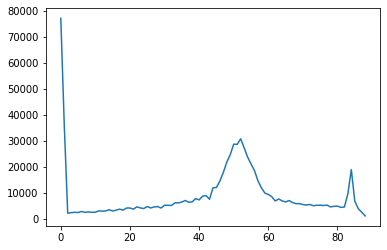

In [88]:
line = d_lines[0]

peak_distance_param=0.25
peak_height_param=0.1
spectr = np.array([len(px) for px in line])

plt.plot(spectr)

In [89]:
def get_most_often_linelen(d_lines, clusters=2):
    pxls  = np.array([len(i) for i in d_lines])
    whitened = whiten(pxls)
    centroids, distortion = kmeans(whitened,clusters)
    clx,_ = vq(whitened,centroids)
    clust = np.argmax([len(clx[clx==c]) for c in np.unique(clx)])
    lines_pxs = np.mean(pxls[clx == clust]).astype(int)
    return lines_pxs, pxls, clx,clust, distortion

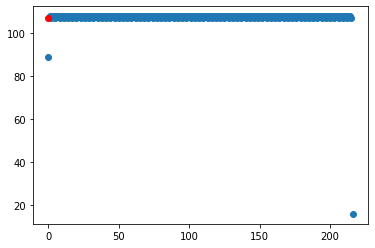

In [90]:
lines_pxs, pxls, clx,clust, distortion = get_most_often_linelen(d_lines, clusters=4)
plt.plot(pxls, 'o')
plt.plot(lines_pxs, 'ro')

In [91]:
pxls  = np.array([len(i) for i in d_lines[clx==clust]])
pxls

array([ 89, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108,
       108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108,
       107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107,
       108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108,
       108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108,
       107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107,
       108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108,
       108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108,
       107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107,
       108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108,
       108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108,
       107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107,
       108, 108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 108,
       108, 107, 108, 108, 107, 108, 108, 107, 108, 108, 107, 10

In [92]:
px_min = min(np.array([len(i) for i in d_lines]))
px_min

16

In [93]:
def align_by_peak(data, trig, line_trig=8, pix_trig=7, peak_distance_param=0.25, peak_height_param=0.1):
    hist, times = np.histogram(data['time_from_trig'], range=(0,trig), bins=100)
    d_0 = np.split(data, np.where(data['channel'] == line_trig)[0][1:])
    d_lines = np.array(list(map(lambda x: np.split(x, np.where(x['channel'] == pix_trig)[0][1:]), d_0)))

    center = lt.get_trig_len(data, trig_ch=line_trig)/2
    for line in d_lines:
        t = [int(px[0]['time']) - int(line[0][0]['time']) for px in line]
        peaks, _ = find_peaks(hist/np.max(hist), height=0.8, distance=len(hist)/2)
        spectr = np.array([len((px[px['time_from_trig'] < 0.5*times[peaks[0]]])) for px in line])
        peaks, _ = find_peaks(spectr/np.max(spectr), peak_height_param, distance=len(spectr)*peak_distance_param)
        if peaks!=[]:
            pk = peaks[spectr[peaks].argmax()]
            shift = t[pk] - center
            line[0][0]['time'] = line[0][0]['time'] + shift

    data = data[np.argsort(data['time'])]
    return data

In [94]:
trig = lt.get_trig_len(data)
data2 = align_by_peak(data, trig)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
d_0 = np.split(data2, np.where(data['channel'] == line_trig)[0])
d_lines = np.array(list(map(lambda x: np.split(x, np.where(x['channel'] == pix_trig)[0]), d_0)))

In [95]:
binNum = 100

In [72]:
img = np.zeros((px_min, binNum))
for line_x in d_lines[1:]:
    line = np.zeros(binNum)
    for px in line_x[0:px_min-1]:
        y,x = np.histogram(px['time_from_trig'], bins=binNum, range=(10, trig))
        line = np.vstack((line, y))
    img = np.dstack((img, line))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 105 and the array at index 1 has size 17

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(img.sum(axis=1).T, aspect='auto')